# VGG16-BN with Attention Blocks

This notebook evaluates the effect of adding attention blocks on pre-trained VGG16-BN model performance.

This section integrates attention mechanisms into VGG16-BN to pay attention to the most relevant features, hence improving feature extraction and reducing overfitting. The Squeeze-and-Excitation (SE) block focuses on channel attention, while the Convolutional Block Attention Module (CBAM) is a hybrid attention model combining channel and spatial attention. This is crucial for the Flowers102 dataset where classes might only differ by subtle cues that might be missed out, such as petal shape and leaf vein patterns.

Using the FC classifier head on the baseline VGG16 model, we evaluated two attention modules by inserting them after the last 3 convolutional blocks. SE variant uses global average pooling followed by a multilayer perceptron, while CBAM variant sequentially uses a channel attention module followed by a spatial attention module. We also explored 3 fine-tuning variants, full, partial and frozen, for each attention module type.


## Imports and Reproducibility Setup

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets, models
from torchvision.datasets import Flowers102
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms import v2
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models import vgg16_bn, VGG16_BN_Weights
from torch.utils.data import DataLoader, default_collate

import matplotlib.pyplot as plt
import random
import numpy as np
from itertools import product
import copy, time

from torch.utils.data import Dataset
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE

NUM_CLASSES = 102

seed = 1001
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
rng = np.random.default_rng(seed)

In [3]:
def pick_device():
    if torch.cuda.is_available():
        return torch.device("cuda"), "CUDA"
    try:
        import torch_directml as dml
        if hasattr(dml, "is_available") and dml.is_available():
            return dml.device(), "DirectML"
    except Exception as e:
        print("DirectML init error:", e)
    if hasattr(torch, "xpu") and getattr(torch.xpu, "is_available", lambda: False)():
        return torch.device("xpu"), "Intel XPU"
    # Fallback
    return torch.device("cpu"), "CPU"

device, backend = pick_device()
print(f"Using backend: {backend} on device: {device}")

Using backend: DirectML on device: privateuseone:0


## Data Preparation and Helper Functions

In [2]:
NUM_CLASSES = 102
BATCH_SIZE = 32
BASE_LR = 5e-4
WEIGHT_DECAY = 1e-4
MAX_EPOCHS = 30
PATIENCE = 5

In [3]:
# resize images to 224x224 in line with ResNet/EfficientNet input size, normalize images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


In [4]:
# load the dataset
train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_dataset   = datasets.Flowers102(root='./data', split='val',   download=True, transform=transform)
test_dataset  = datasets.Flowers102(root='./data', split='test',  download=True, transform=transform)


In [5]:
# create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=4)


In [6]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0.0, verbose=True, model_path='model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
        self.verbose = verbose
        self.model_path = model_path

    def early_stop(self, validation_loss, model):
        if validation_loss < self.min_validation_loss - self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0
            if self.model_path is not None:
                torch.save(model.state_dict(), self.model_path)
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.verbose:
                    print("Early stopping triggered.")
                return True
        return False

In [7]:
# Attention Blocks: SE & CBAM

class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation block (channel attention).
    """
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels // reduction, bias=True)
        self.fc2 = nn.Linear(channels // reduction, channels, bias=True)

    def forward(self, x):
        b, c, _, _ = x.size()
        # Squeeze: global average pooling
        y = x.view(b, c, -1).mean(dim=2)
        # Excitation: bottleneck MLP
        y = F.relu(self.fc1(y), inplace=True)
        y = torch.sigmoid(self.fc2(y))
        y = y.view(b, c, 1, 1)
        return x * y


class CBAMChannelAttention(nn.Module):
    """
    Channel attention sub-module for CBAM.
    """
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False)
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        avg_pool = x.view(b, c, -1).mean(dim=2)
        max_pool, _ = x.view(b, c, -1).max(dim=2)

        avg_out = self.mlp(avg_pool)
        max_out = self.mlp(max_pool)

        scale = torch.sigmoid(avg_out + max_out).view(b, c, 1, 1)
        return x * scale


class CBAMSpatialAttention(nn.Module):
    """
    Spatial attention sub-module for CBAM.
    """
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size,
                              padding=padding, bias=False)

    def forward(self, x):
        # Channel-wise avg and max
        avg_pool = x.mean(dim=1, keepdim=True)
        max_pool, _ = x.max(dim=1, keepdim=True)
        attn = torch.cat([avg_pool, max_pool], dim=1)
        attn = self.conv(attn)
        scale = torch.sigmoid(attn)
        return x * scale


class CBAMBlock(nn.Module):
    """
    Convolutional Block Attention Module (CBAM):
    Channel attention -> Spatial attention.
    """
    def __init__(self, channels, reduction=16, spatial_kernel=7):
        super().__init__()
        self.channel_att = CBAMChannelAttention(channels, reduction)
        self.spatial_att = CBAMSpatialAttention(spatial_kernel)

    def forward(self, x):
        x = self.channel_att(x)
        x = self.spatial_att(x)
        return x

In [8]:
# VGG16-BN with Pluggable Attention + Configurable Head

class VGG16BNWithAttention(nn.Module):
    """
    Wrapper around torchvision VGG16-BN:
    - Optional SE / CBAM after selected conv blocks (here: last 3 blocks).
    - Head choice:
        * 'fc'  : original VGG-style classifier (modified for 102 classes)
        * 'gap' : GAP -> Dropout -> Linear
    """
    def __init__(self,
                 att_type="none",          # 'none' | 'se' | 'cbam'
                 head_type="gap",          # 'gap'  | 'fc'
                 num_classes=NUM_CLASSES,
                 pretrained=True):
        super().__init__()

        # ---- Base backbone ----
        if pretrained:
            base = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)
        else:
            base = models.vgg16_bn(weights=None)

        # Split into conv blocks by MaxPool
        features = list(base.features.children())
        blocks = []
        current = []
        for layer in features:
            current.append(layer)
            if isinstance(layer, nn.MaxPool2d):
                blocks.append(nn.Sequential(*current))
                current = []
        if current:
            blocks.append(nn.Sequential(*current))

        # VGG16-BN conv block output channels
        # conv blocks: [64, 128, 256, 512, 512]
        block_out_channels = [64, 128, 256, 512, 512]

        self.att_type = att_type.lower()
        self.head_type = head_type.lower()

        self.blocks = nn.ModuleList()
        for i, block in enumerate(blocks):
            self.blocks.append(block)
            # Insert attention after last three blocks (256/512/512)
            if self.att_type == "se" and i >= 2:
                self.blocks.append(SEBlock(block_out_channels[i]))
            elif self.att_type == "cbam" and i >= 2:
                self.blocks.append(CBAMBlock(block_out_channels[i]))

        # ---- Classification head ----
        if self.head_type == "fc":
            # Use original-style FC head but adjusted for Flowers102
            # Input: 512 * 7 * 7 for 224x224 with VGG16 pooling schedule
            self.classifier = nn.Sequential(
                nn.Linear(512 * 7 * 7, 4096),
                nn.ReLU(True),
                nn.Dropout(0.5),
                nn.Linear(4096, 4096),
                nn.ReLU(True),
                nn.Dropout(0.5),
                nn.Linear(4096, num_classes),
            )
        elif self.head_type == "gap":
            # Global Average Pooling head:
            # GAP -> Dropout -> Linear
            self.classifier = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(512, num_classes),
            )
        else:
            raise ValueError("head_type must be 'fc' or 'gap'.")

    def forward(self, x):
        for m in self.blocks:
            x = m(x)
        if self.head_type == "gap":
            x = F.adaptive_avg_pool2d(x, (1, 1))
            x = torch.flatten(x, 1)
            x = self.classifier(x)
        else:
            # 'fc' head
            x = torch.flatten(x, 1)
            x = self.classifier(x)
        return x


In [9]:
# Helper: Build Model with Freeze Modes

def build_vgg16bn_attention(att_type="none",
                            head_type="gap",
                            freeze_mode="frozen",
                            num_classes=NUM_CLASSES):
    """
    freeze_mode:
      - 'frozen' : freeze all conv blocks, train only classifier.
      - 'partial'     : freeze early blocks, fine-tune last two conv blocks + head.
      - 'full'        : fine-tune everything.
    """
    model = VGG16BNWithAttention(
        att_type=att_type,
        head_type=head_type,
        num_classes=num_classes,
        pretrained=True
    )

    # By construction, conv blocks are in model.blocks
    # Identify which indices correspond to conv blocks vs attention:
    # We appended [block, (optional attention), block, (optional attention), ...]
    conv_block_indices = []
    for idx, m in enumerate(model.blocks):
        # crude heuristic: blocks are Sequential; attention blocks are SEBlock/CBAMBlock
        if isinstance(m, nn.Sequential):
            conv_block_indices.append(idx)

    if freeze_mode == "frozen":
        # freeze all backbone, train only classifier
        for param in model.blocks.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True

    elif freeze_mode == "partial":
        # freeze first N conv blocks, unfreeze last two conv blocks + attention + head
        # with 5 conv blocks in VGG16-BN, freeze first 3
        freeze_until = 3
        for block_idx in conv_block_indices[:freeze_until]:
            for p in model.blocks[block_idx].parameters():
                p.requires_grad = False
        # everything else (later convs, attention, classifier) stays trainable
        # (default requires_grad=True)

    elif freeze_mode == "full":
        # all trainable
        for p in model.parameters():
            p.requires_grad = True
    else:
        raise ValueError("freeze_mode must be 'frozen', 'partial' or 'full'.")

    return model


In [19]:
# Training / Evaluation Utilities

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for X, y in loader:


        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += X.size(0)

    return total_loss / total, correct / total


def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in loader:

            logits = model(X)
            loss = criterion(logits, y)

            total_loss += loss.item() * X.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += X.size(0)

    return total_loss / total, correct / total


def run_vgg_attention_experiment(
    name,
    att_type="none",
    head_type="gap",
    freeze_mode="frozen",
    lr=BASE_LR,
    weight_decay=WEIGHT_DECAY,
    num_epochs=100,
    patience=PATIENCE,
    model_path=None
):
    if model_path is None:
        model_path = f"vgg16bn_{name}.pth"

    print(f"\n{'='*70}")
    print(f"Experiment: {name}")
    print(f"Attention: {att_type} | Head: {head_type} | Freeze: {freeze_mode}")
    print(f"{'='*70}")

    model = build_vgg16bn_attention(
        att_type=att_type,
        head_type=head_type,
        freeze_mode=freeze_mode,
        num_classes=NUM_CLASSES
    )

    # Only optimize trainable params
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(params, lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    stopper = EarlyStopper(patience=patience, min_delta=0.0,
                           verbose=True, model_path=model_path)

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
    }

    best_val_acc = 0.0

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc     = evaluate(model, val_loader, criterion)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"[{name}] Epoch {epoch:02d} | "
              f"Train Loss: {train_loss:.4f} / Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} / Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc

        if stopper.early_stop(val_loss, model):
            break

    # Load best weights
    best_model = build_vgg16bn_attention(
        att_type=att_type,
        head_type=head_type,
        freeze_mode="full",          # doesn't matter; will overwrite weights
        num_classes=NUM_CLASSES
    )
    best_model.load_state_dict(torch.load(model_path))


    # Final test evaluation
    test_loss, test_acc = evaluate(best_model, test_loader, criterion)
    print(f"\n[{name}] Best Val Acc: {best_val_acc:.4f} | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

    return best_model, history, best_val_acc, test_acc

In [20]:
def plot_history(history, title_prefix=""):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(10, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train")
    plt.plot(epochs, history["val_loss"],   label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train")
    plt.plot(epochs, history["val_acc"],   label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## Training Loop

Here are the variants tested:
| Modification      | Variant       | 
|-----------------|-----------------|
| Attention Module  | SE, CBAM   | 
| Fine-tuning Strategy | Full, Partial, Frozen | 

In [23]:
# Run ALL VGG16-BN Attention x Freeze permutations

results = {}

# 1. SE attention, Full


se_fc_full_model, se_fc_full_hist, se_fc_full_val, se_fc_full_test = run_vgg_attention_experiment(
    name="se_fc_full",
    att_type="se",
    head_type="fc",
    freeze_mode="full",
    num_epochs=30,
    model_path="vgg16bn_se_fc_full.pth",
)

results["se_fc_full"] = (se_fc_full_val, se_fc_full_test)

# 2. CBAM attention, Full

cbam_fc_full_model, cbam_fc_full_hist, cbam_fc_full_val, cbam_fc_full_test = run_vgg_attention_experiment(
    name="cbam_fc_full",
    att_type="cbam",
    head_type="fc",
    freeze_mode="full",
    num_epochs=30,
    model_path="vgg16bn_cbam_fc_full.pth",
)

results["cbam_fc_full"] = (cbam_fc_full_val, cbam_fc_full_test)


# Optional: quick summary printout
for k, (best_val, test_acc) in results.items():
    print(f"{k:20s} | Best Val Acc: {best_val:.4f} | Test Acc: {test_acc:.4f}")


Experiment: se_fc_full
Attention: se | Head: fc | Freeze: full
[se_fc_full] Epoch 01 | Train Loss: 4.6060 / Train Acc: 0.0069 | Val Loss: 4.5900 / Val Acc: 0.0147
[se_fc_full] Epoch 02 | Train Loss: 4.4650 / Train Acc: 0.0108 | Val Loss: 4.4428 / Val Acc: 0.0255
[se_fc_full] Epoch 03 | Train Loss: 4.3819 / Train Acc: 0.0157 | Val Loss: 4.2820 / Val Acc: 0.0333
[se_fc_full] Epoch 04 | Train Loss: 4.2467 / Train Acc: 0.0275 | Val Loss: 4.2679 / Val Acc: 0.0392
[se_fc_full] Epoch 05 | Train Loss: 4.0118 / Train Acc: 0.0578 | Val Loss: 4.0995 / Val Acc: 0.0569
[se_fc_full] Epoch 06 | Train Loss: 3.8563 / Train Acc: 0.0892 | Val Loss: 3.9758 / Val Acc: 0.0833
[se_fc_full] Epoch 07 | Train Loss: 3.6635 / Train Acc: 0.1059 | Val Loss: 4.3328 / Val Acc: 0.1039
[se_fc_full] Epoch 08 | Train Loss: 3.3577 / Train Acc: 0.1559 | Val Loss: 3.7830 / Val Acc: 0.1216
[se_fc_full] Epoch 09 | Train Loss: 3.0458 / Train Acc: 0.2245 | Val Loss: 3.7861 / Val Acc: 0.1480
[se_fc_full] Epoch 10 | Train Loss: 

C:\Users\nguiy\AppData\Local\Temp\ipykernel_19868\2189815591.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path))



[se_fc_full] Best Val Acc: 0.2618 | Test Loss: 3.6611 | Test Acc: 0.1979

Experiment: cbam_fc_full
Attention: cbam | Head: fc | Freeze: full
[cbam_fc_full] Epoch 01 | Train Loss: 4.6356 / Train Acc: 0.0147 | Val Loss: 4.8140 / Val Acc: 0.0108
[cbam_fc_full] Epoch 02 | Train Loss: 4.5104 / Train Acc: 0.0147 | Val Loss: 4.8148 / Val Acc: 0.0255
[cbam_fc_full] Epoch 03 | Train Loss: 4.3199 / Train Acc: 0.0333 | Val Loss: 4.1598 / Val Acc: 0.0480
[cbam_fc_full] Epoch 04 | Train Loss: 4.0239 / Train Acc: 0.0745 | Val Loss: 4.4605 / Val Acc: 0.0412
[cbam_fc_full] Epoch 05 | Train Loss: 3.8501 / Train Acc: 0.0794 | Val Loss: 4.0735 / Val Acc: 0.0794
[cbam_fc_full] Epoch 06 | Train Loss: 3.6603 / Train Acc: 0.1118 | Val Loss: 3.8409 / Val Acc: 0.0882
[cbam_fc_full] Epoch 07 | Train Loss: 3.4047 / Train Acc: 0.1422 | Val Loss: 3.8984 / Val Acc: 0.0961
[cbam_fc_full] Epoch 08 | Train Loss: 3.1542 / Train Acc: 0.1912 | Val Loss: 3.7274 / Val Acc: 0.1157
[cbam_fc_full] Epoch 09 | Train Loss: 2.99

In [31]:
# 3. SE attention, Partial

se_fc_partial_model, se_fc_partial_hist, se_fc_partial_val, se_fc_partial_test = run_vgg_attention_experiment(
    name="se_fc_partial",
    att_type="se",
    head_type="fc",
    freeze_mode="partial",
    num_epochs=30,
    model_path="vgg16bn_se_fc_partial.pth",
)

results["se_fc_partial"] = (se_fc_partial_val, se_fc_partial_test)

# 4. CBAM attention, Partial

cbam_fc_partial_model, cbam_fc_partial_hist, cbam_fc_partial_val, cbam_fc_partial_test = run_vgg_attention_experiment(
    name="cbam_fc_partial",
    att_type="cbam",
    head_type="fc",
    freeze_mode="partial",
    num_epochs=30,
    model_path="vgg16bn_cbam_fc_partial.pth",
)

results["cbam_fc_partial"] = (cbam_fc_partial_val, cbam_fc_partial_test)


# Optional: quick summary printout
for k, (best_val, test_acc) in results.items():
    print(f"{k:20s} | Best Val Acc: {best_val:.4f} | Test Acc: {test_acc:.4f}")


Experiment: se_fc_partial
Attention: se | Head: fc | Freeze: partial
[se_fc_partial] Epoch 01 | Train Loss: 4.5929 / Train Acc: 0.0206 | Val Loss: 4.9635 / Val Acc: 0.0314
[se_fc_partial] Epoch 02 | Train Loss: 4.4082 / Train Acc: 0.0510 | Val Loss: 4.5741 / Val Acc: 0.0520
[se_fc_partial] Epoch 03 | Train Loss: 4.3225 / Train Acc: 0.0608 | Val Loss: 4.3895 / Val Acc: 0.0559
[se_fc_partial] Epoch 04 | Train Loss: 3.9623 / Train Acc: 0.0902 | Val Loss: 3.8606 / Val Acc: 0.1020
[se_fc_partial] Epoch 05 | Train Loss: 3.4728 / Train Acc: 0.1490 | Val Loss: 3.7281 / Val Acc: 0.1598
[se_fc_partial] Epoch 06 | Train Loss: 2.9626 / Train Acc: 0.2471 | Val Loss: 3.0292 / Val Acc: 0.2529
[se_fc_partial] Epoch 07 | Train Loss: 2.5660 / Train Acc: 0.3245 | Val Loss: 3.2739 / Val Acc: 0.2431
[se_fc_partial] Epoch 08 | Train Loss: 2.0077 / Train Acc: 0.4304 | Val Loss: 2.9400 / Val Acc: 0.2922
[se_fc_partial] Epoch 09 | Train Loss: 1.7028 / Train Acc: 0.5020 | Val Loss: 3.3441 / Val Acc: 0.2824
[se

C:\Users\nguiy\AppData\Local\Temp\ipykernel_19868\2189815591.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path))



[se_fc_partial] Best Val Acc: 0.4333 | Test Loss: 3.0228 | Test Acc: 0.3845

Experiment: cbam_fc_partial
Attention: cbam | Head: fc | Freeze: partial
[cbam_fc_partial] Epoch 01 | Train Loss: 4.6170 / Train Acc: 0.0088 | Val Loss: 4.4269 / Val Acc: 0.0382
[cbam_fc_partial] Epoch 02 | Train Loss: 4.4084 / Train Acc: 0.0402 | Val Loss: 4.4444 / Val Acc: 0.0412
[cbam_fc_partial] Epoch 03 | Train Loss: 4.1275 / Train Acc: 0.0618 | Val Loss: 4.3497 / Val Acc: 0.0559
[cbam_fc_partial] Epoch 04 | Train Loss: 3.8471 / Train Acc: 0.0824 | Val Loss: 4.0708 / Val Acc: 0.0745
[cbam_fc_partial] Epoch 05 | Train Loss: 3.4902 / Train Acc: 0.1304 | Val Loss: 3.7426 / Val Acc: 0.1088
[cbam_fc_partial] Epoch 06 | Train Loss: 3.0815 / Train Acc: 0.1843 | Val Loss: 3.5977 / Val Acc: 0.1608
[cbam_fc_partial] Epoch 07 | Train Loss: 2.6497 / Train Acc: 0.2559 | Val Loss: 3.1586 / Val Acc: 0.2363
[cbam_fc_partial] Epoch 08 | Train Loss: 2.2198 / Train Acc: 0.3520 | Val Loss: 3.8101 / Val Acc: 0.1843
[cbam_fc_

In [43]:
# 5. SE attention, Frozen


se_fc_frozen_model, se_fc_frozen_hist, se_fc_frozen_val, se_fc_frozen_test = run_vgg_attention_experiment(
    name="se_fc_frozen",
    att_type="se",
    head_type="fc",
    freeze_mode="frozen",
    num_epochs=30,
    model_path="vgg16bn_se_fc_frozen.pth",
)

results["se_fc_frozen"] = (se_fc_frozen_val, se_fc_frozen_test)

# 6. CBAM attention, Frozen

cbam_fc_frozen_model, cbam_fc_frozen_hist, cbam_fc_frozen_val, cbam_fc_frozen_test = run_vgg_attention_experiment(
    name="cbam_fc_frozen",
    att_type="cbam",
    head_type="fc",
    freeze_mode="frozen",
    num_epochs=30,
    model_path="vgg16bn_cbam_fc_frozen.pth",
)

results["cbam_fc_frozen"] = (cbam_fc_frozen_val, cbam_fc_frozen_test)


# Optional: quick summary printout
for k, (best_val, test_acc) in results.items():
    print(f"{k:20s} | Best Val Acc: {best_val:.4f} | Test Acc: {test_acc:.4f}")


Experiment: se_fc_frozen
Attention: se | Head: fc | Freeze: frozen
[se_fc_frozen] Epoch 01 | Train Loss: 4.6996 / Train Acc: 0.0118 | Val Loss: 4.4134 / Val Acc: 0.1176
[se_fc_frozen] Epoch 02 | Train Loss: 3.7305 / Train Acc: 0.2039 | Val Loss: 3.0845 / Val Acc: 0.2971
[se_fc_frozen] Epoch 03 | Train Loss: 1.6989 / Train Acc: 0.5980 | Val Loss: 1.7415 / Val Acc: 0.5696
[se_fc_frozen] Epoch 04 | Train Loss: 0.3951 / Train Acc: 0.9157 | Val Loss: 1.2622 / Val Acc: 0.6775
[se_fc_frozen] Epoch 05 | Train Loss: 0.0940 / Train Acc: 0.9853 | Val Loss: 0.9949 / Val Acc: 0.7608
[se_fc_frozen] Epoch 06 | Train Loss: 0.0276 / Train Acc: 0.9980 | Val Loss: 0.9548 / Val Acc: 0.7775
[se_fc_frozen] Epoch 07 | Train Loss: 0.0105 / Train Acc: 0.9990 | Val Loss: 0.9192 / Val Acc: 0.7716
[se_fc_frozen] Epoch 08 | Train Loss: 0.0084 / Train Acc: 1.0000 | Val Loss: 0.8357 / Val Acc: 0.7882
[se_fc_frozen] Epoch 09 | Train Loss: 0.0046 / Train Acc: 1.0000 | Val Loss: 0.8235 / Val Acc: 0.7980
[se_fc_frozen]

C:\Users\nguiy\AppData\Local\Temp\ipykernel_19868\2189815591.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_path))



[se_fc_frozen] Best Val Acc: 0.8118 | Test Loss: 0.8708 | Test Acc: 0.7749

Experiment: cbam_fc_frozen
Attention: cbam | Head: fc | Freeze: frozen
[cbam_fc_frozen] Epoch 01 | Train Loss: 4.6831 / Train Acc: 0.0167 | Val Loss: 4.5505 / Val Acc: 0.1000
[cbam_fc_frozen] Epoch 02 | Train Loss: 4.0740 / Train Acc: 0.1480 | Val Loss: 3.3751 / Val Acc: 0.2912
[cbam_fc_frozen] Epoch 03 | Train Loss: 2.2192 / Train Acc: 0.4784 | Val Loss: 2.0868 / Val Acc: 0.4647
[cbam_fc_frozen] Epoch 04 | Train Loss: 0.6414 / Train Acc: 0.8578 | Val Loss: 1.4651 / Val Acc: 0.6167
[cbam_fc_frozen] Epoch 05 | Train Loss: 0.1622 / Train Acc: 0.9696 | Val Loss: 1.2003 / Val Acc: 0.6735
[cbam_fc_frozen] Epoch 06 | Train Loss: 0.0461 / Train Acc: 0.9941 | Val Loss: 1.0587 / Val Acc: 0.7265
[cbam_fc_frozen] Epoch 07 | Train Loss: 0.0229 / Train Acc: 0.9971 | Val Loss: 0.9928 / Val Acc: 0.7324
[cbam_fc_frozen] Epoch 08 | Train Loss: 0.0142 / Train Acc: 0.9990 | Val Loss: 0.9120 / Val Acc: 0.7559
[cbam_fc_frozen] Epo

## Data Visualisation and Plots

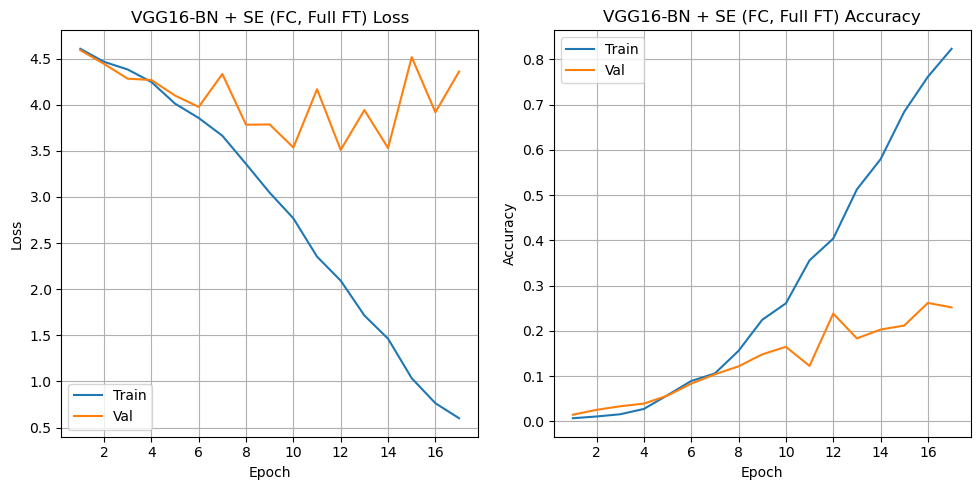

In [33]:
plot_history(se_fc_full_hist, "VGG16-BN + SE (FC, Full FT)")

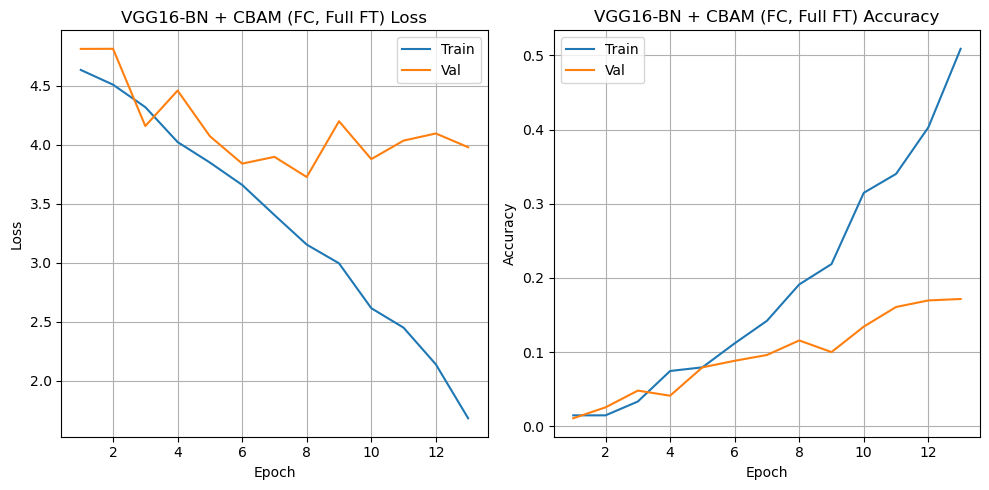

In [35]:
plot_history(cbam_fc_full_hist, "VGG16-BN + CBAM (FC, Full FT)")

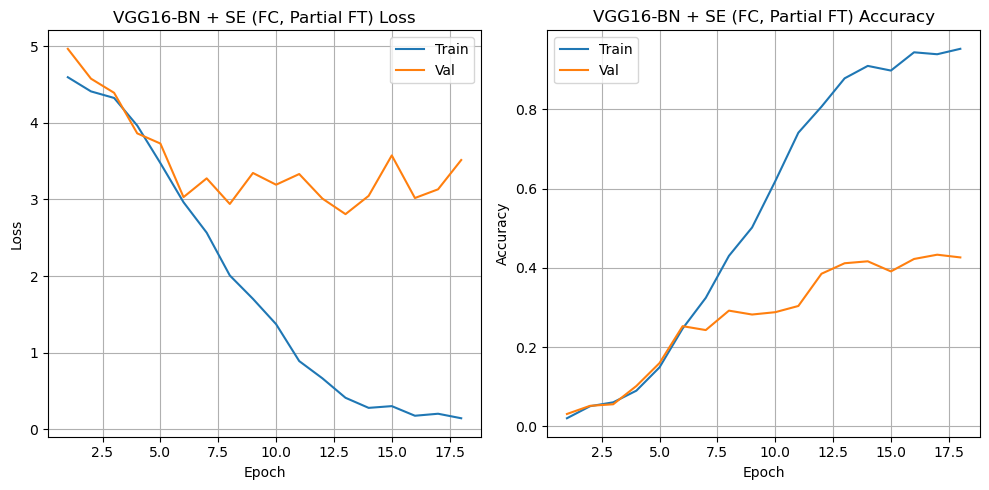

In [37]:
plot_history(se_fc_partial_hist, "VGG16-BN + SE (FC, Partial FT)")

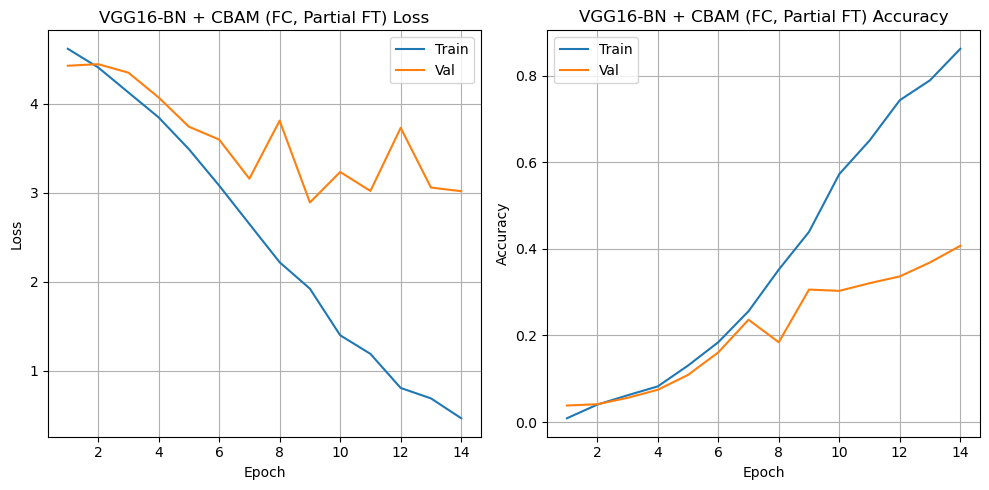

In [39]:
plot_history(cbam_fc_partial_hist, "VGG16-BN + CBAM (FC, Partial FT)")

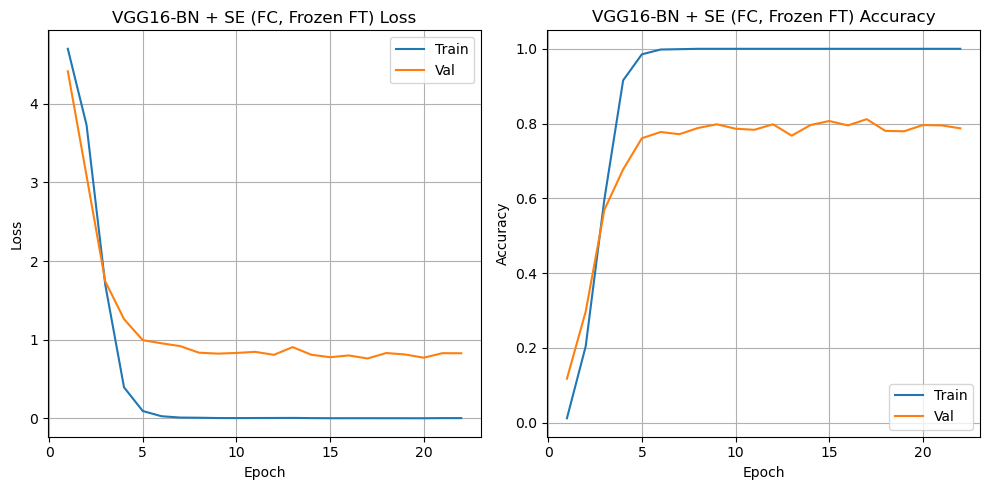

In [45]:
plot_history(se_fc_frozen_hist, "VGG16-BN + SE (FC, Frozen FT)")

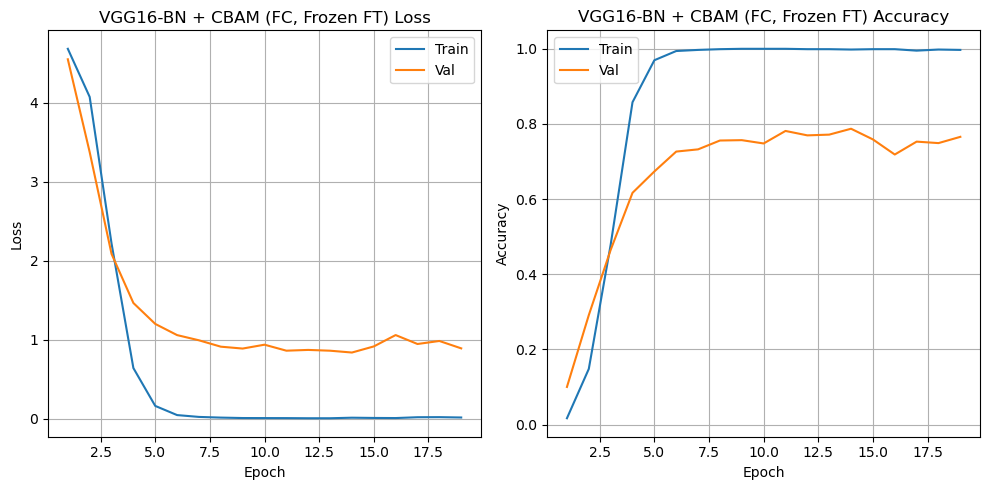

In [47]:
plot_history(cbam_fc_frozen_hist, "VGG16-BN + CBAM (FC, Frozen FT)")

se_fc_full                | Best Val Acc: 0.2618 | Test Acc: 0.1979
cbam_fc_full              | Best Val Acc: 0.1716 | Test Acc: 0.1129
se_fc_partial             | Best Val Acc: 0.4333 | Test Acc: 0.3845
cbam_fc_partial           | Best Val Acc: 0.4069 | Test Acc: 0.2882
se_fc_frozen              | Best Val Acc: 0.8118 | Test Acc: 0.7749
cbam_fc_frozen            | Best Val Acc: 0.7873 | Test Acc: 0.7549


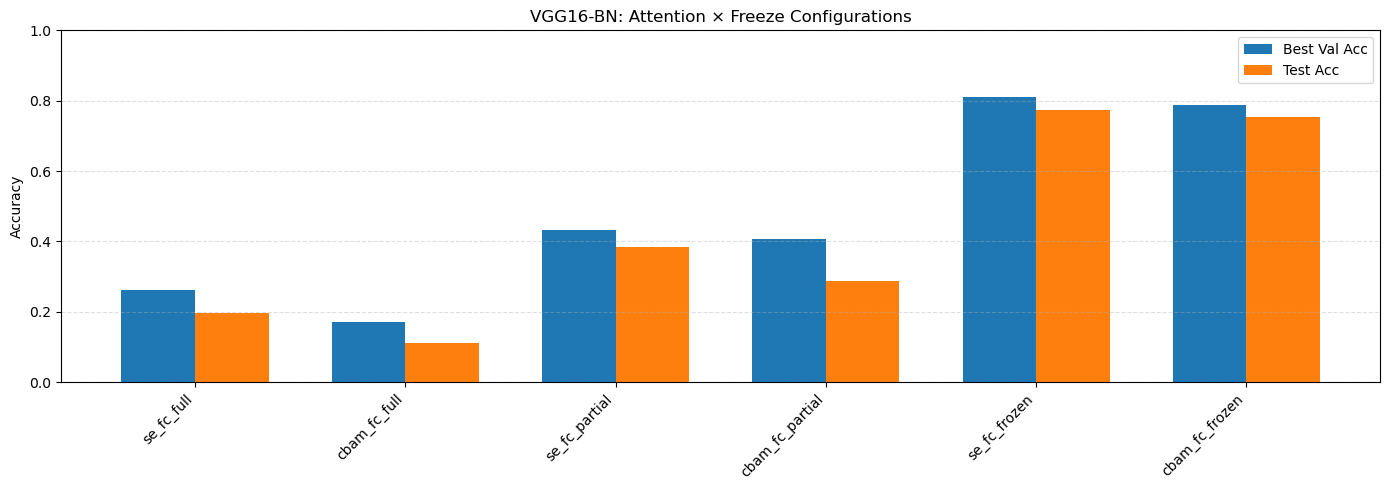

In [49]:
# Build summary dict from results
vgg_summary = {
    name: {
        "best_val_acc": best_val,
        "test_acc": test_acc
    }
    for name, (best_val, test_acc) in results.items()
}

for k, vals in vgg_summary.items():
    print(f"{k:25s} | Best Val Acc: {vals['best_val_acc']:.4f} | Test Acc: {vals['test_acc']:.4f}")


# Plot summary bar chart
def plot_vgg_attention_summary_bar(summary_dict):
    labels = list(summary_dict.keys())
    val_scores = [summary_dict[k]["best_val_acc"] for k in labels]
    test_scores = [summary_dict[k]["test_acc"] for k in labels]

    x = np.arange(len(labels))
    w = 0.35

    plt.figure(figsize=(14, 5))
    plt.bar(x - w/2, val_scores, width=w, label="Best Val Acc")
    plt.bar(x + w/2, test_scores, width=w, label="Test Acc")
    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylim(0.0, 1.0)
    plt.ylabel("Accuracy")
    plt.title("VGG16-BN: Attention × Freeze Configurations")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_vgg_attention_summary_bar(vgg_summary)
